# Markdown 標記操作
+ 選擇cell，按下ESC 再按下M，進入編輯模式
+ 完成後按下 cammand + return 即完成設定
+ 詳細教學 https://py3data.blogspot.com/2019/01/3jupyter.html

# 建立第一個資料庫
#### 了解資料庫操作基本原理

In [1]:
import sqlite3
import pandas as pd
from itertools import combinations
import random

# 連接資料庫
conn = sqlite3.connect('lottery.db')

# 查詢大樂透所有主號碼的出現頻率
query = """
SELECT 
    n.number,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(DISTINCT draw_id) FROM lottery_numbers 
                                WHERE draw_id IN (SELECT id FROM lottery_draws WHERE game_type = '大樂透')), 2) as probability
FROM lottery_numbers n
JOIN lottery_draws d ON n.draw_id = d.id
WHERE d.game_type = '大樂透' 
  AND n.number_type = 'main'
GROUP BY n.number
ORDER BY count DESC
"""

# 執行查詢
df_freq = pd.read_sql_query(query, conn)

print("=" * 60)
print("📊 大樂透號碼出現頻率統計（Top 20）")
print("=" * 60)
print(f"\n{'排名':<6} {'號碼':<6} {'出現次數':<10} {'出現機率':<10}")
print("-" * 60)

for idx, row in df_freq.head(20).iterrows():
    print(f"{idx+1:<6} {int(row['number']):>4}   {int(row['count']):<10} {row['probability']:<10}%")

conn.close()

📊 大樂透號碼出現頻率統計（Top 20）

排名     號碼     出現次數       出現機率      
------------------------------------------------------------
1         8   282        13.72     %
2         2   276        13.42     %
3        15   273        13.28     %
4         1   273        13.28     %
5        41   270        13.13     %
6        35   270        13.13     %
7        30   269        13.08     %
8        23   269        13.08     %
9        22   266        12.94     %
10       43   265        12.89     %
11       36   263        12.79     %
12       11   263        12.79     %
13       32   261        12.69     %
14       21   259        12.6      %
15       13   259        12.6      %
16        7   257        12.5      %
17       26   256        12.45     %
18       37   255        12.4      %
19       29   255        12.4      %
20       27   254        12.35     %


# 大樂透號碼機率分析與推薦組合

## 分析說明

本分析基於 lottery.db 資料庫中 2007-2025 年的大樂透歷史開獎資料（共 2,056 期）進行統計分析。

### 分析方法

1. **號碼出現頻率統計**：計算每個號碼（1-49）在歷年所有期別中作為主號碼出現的次數及機率
2. **組合生成策略**：從最常出現的 Top 15 號碼中隨機組合，生成 20 組推薦號碼
3. **綜合機率排序**：根據組合中所有號碼的平均出現機率進行排序

### 注意事項

⚠️ **本分析僅供參考，彩票開獎為隨機事件，過去的統計數據不代表未來結果。**

---

In [2]:
# 生成20組基於最常出現號碼的組合
conn = sqlite3.connect('lottery.db')

# 重新獲取號碼頻率資料
query = """
SELECT 
    n.number,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(DISTINCT draw_id) FROM lottery_numbers 
                                WHERE draw_id IN (SELECT id FROM lottery_draws WHERE game_type = '大樂透')), 2) as probability
FROM lottery_numbers n
JOIN lottery_draws d ON n.draw_id = d.id
WHERE d.game_type = '大樂透' 
  AND n.number_type = 'main'
GROUP BY n.number
ORDER BY count DESC
"""

df_freq = pd.read_sql_query(query, conn)

# 取得最常出現的號碼（Top 15）作為候選池
top_numbers = df_freq.head(15)['number'].tolist()

print("\n" + "=" * 80)
print("🎯 基於最高機率號碼的 20 組推薦組合")
print("=" * 80)
print("\n候選號碼池（Top 15 最常出現）：", sorted([int(n) for n in top_numbers]))
print("\n")

# 生成20組不重複的6號碼組合
# 策略：從Top 15號碼中隨機選取，確保多樣性
all_combinations = []
attempts = 0
max_attempts = 1000

while len(all_combinations) < 20 and attempts < max_attempts:
    # 隨機選擇6個號碼
    combo = tuple(sorted(random.sample(top_numbers, 6)))
    
    # 確保組合不重複
    if combo not in all_combinations:
        all_combinations.append(combo)
    
    attempts += 1

# 計算每組組合的綜合機率（號碼平均出現率）
combinations_with_prob = []
for combo in all_combinations:
    avg_prob = df_freq[df_freq['number'].isin(combo)]['probability'].mean()
    combinations_with_prob.append((combo, avg_prob))

# 按照綜合機率排序
combinations_with_prob.sort(key=lambda x: x[1], reverse=True)

# 顯示結果
print(f"{'組別':<6} {'號碼組合':<35} {'平均出現機率':<15}")
print("-" * 80)

for idx, (combo, avg_prob) in enumerate(combinations_with_prob, 1):
    numbers_str = ', '.join([f"{int(n):02d}" for n in combo])
    print(f"{idx:<6} {numbers_str:<35} {avg_prob:.2f}%")

# 顯示每組的詳細機率
print("\n" + "=" * 80)
print("📈 各組合中每個號碼的出現機率詳情（前5組）")
print("=" * 80)

for idx, (combo, avg_prob) in enumerate(combinations_with_prob[:5], 1):
    print(f"\n第 {idx} 組：{', '.join([f'{int(n):02d}' for n in combo])} (平均機率: {avg_prob:.2f}%)")
    print("-" * 60)
    
    for num in sorted(combo):
        num_data = df_freq[df_freq['number'] == num].iloc[0]
        rank = df_freq[df_freq['number'] == num].index[0] + 1
        print(f"  號碼 {int(num):02d}: 出現 {int(num_data['count']):>4} 次 | 機率 {num_data['probability']:>5}% | 排名 #{rank}")

conn.close()


🎯 基於最高機率號碼的 20 組推薦組合

候選號碼池（Top 15 最常出現）： [1, 2, 8, 11, 13, 15, 21, 22, 23, 30, 32, 35, 36, 41, 43]


組別     號碼組合                                平均出現機率         
--------------------------------------------------------------------------------
1      01, 02, 08, 23, 30, 35              13.29%
2      01, 08, 11, 15, 30, 43              13.17%
3      01, 08, 30, 32, 35, 41              13.17%
4      01, 08, 11, 15, 32, 35              13.15%
5      02, 08, 11, 15, 21, 23              13.15%
6      02, 08, 11, 15, 22, 32              13.14%
7      01, 02, 15, 35, 36, 43              13.13%
8      01, 02, 13, 15, 23, 43              13.09%
9      08, 13, 23, 35, 36, 41              13.07%
10     01, 02, 11, 13, 15, 22              13.05%
11     02, 08, 21, 30, 32, 36              13.05%
12     08, 21, 22, 23, 35, 36              13.04%
13     01, 15, 21, 30, 35, 36              13.03%
14     15, 30, 32, 35, 36, 43              12.98%
15     08, 11, 21, 22, 36, 43              12.95%
16     

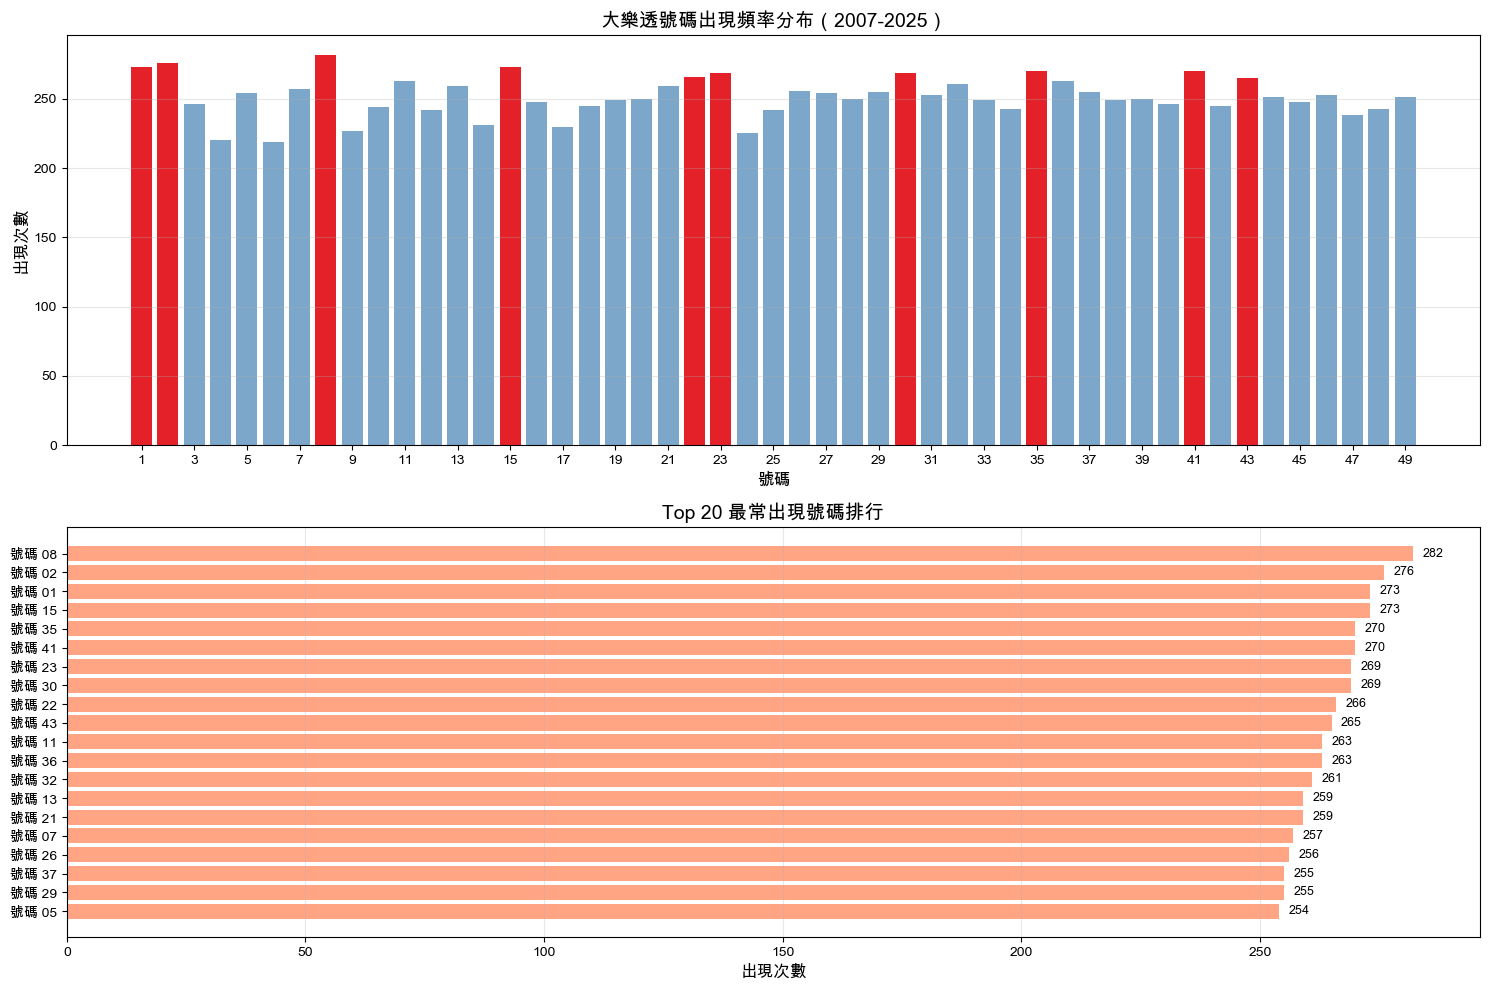


✅ 圖表已儲存為 lottery_analysis.png


In [3]:
# 視覺化分析
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'Microsoft YaHei']
matplotlib.rcParams['axes.unicode_minus'] = False

conn = sqlite3.connect('lottery.db')

# 獲取所有號碼的出現頻率
query = """
SELECT 
    n.number,
    COUNT(*) as count
FROM lottery_numbers n
JOIN lottery_draws d ON n.draw_id = d.id
WHERE d.game_type = '大樂透' 
  AND n.number_type = 'main'
GROUP BY n.number
ORDER BY n.number
"""

df_all = pd.read_sql_query(query, conn)

# 建立圖表
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 圖1: 所有號碼出現頻率
axes[0].bar(df_all['number'], df_all['count'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('號碼', fontsize=12)
axes[0].set_ylabel('出現次數', fontsize=12)
axes[0].set_title('大樂透號碼出現頻率分布（2007-2025）', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticks(range(1, 50, 2))

# 標記Top 10熱門號碼
top10 = df_all.nlargest(10, 'count')
for idx, row in top10.iterrows():
    axes[0].bar(row['number'], row['count'], color='red', alpha=0.8)

# 圖2: Top 20 號碼出現次數（橫條圖）
top20 = df_all.nlargest(20, 'count').sort_values('count')
axes[1].barh(range(len(top20)), top20['count'], color='coral', alpha=0.7)
axes[1].set_yticks(range(len(top20)))
axes[1].set_yticklabels([f"號碼 {int(n):02d}" for n in top20['number']])
axes[1].set_xlabel('出現次數', fontsize=12)
axes[1].set_title('Top 20 最常出現號碼排行', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# 在橫條上顯示數值
for i, (idx, row) in enumerate(top20.iterrows()):
    axes[1].text(row['count'] + 2, i, str(int(row['count'])), 
                va='center', fontsize=9)

plt.tight_layout()
plt.savefig('lottery_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 圖表已儲存為 lottery_analysis.png")

conn.close()

# 🎰 智慧選號器

基於歷史資料，從 Top 30 最熱門號碼中為您隨機產生一組幸運號碼！

In [4]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import sqlite3
import pandas as pd
import random

# 建立輸出區域
output = widgets.Output()

# 從資料庫獲取 Top 30 熱門號碼
def get_top_numbers(limit=30):
    conn = sqlite3.connect('lottery.db')
    query = """
    SELECT 
        n.number,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(DISTINCT draw_id) FROM lottery_numbers 
                                    WHERE draw_id IN (SELECT id FROM lottery_draws WHERE game_type = '大樂透')), 2) as probability
    FROM lottery_numbers n
    JOIN lottery_draws d ON n.draw_id = d.id
    WHERE d.game_type = '大樂透' 
      AND n.number_type = 'main'
    GROUP BY n.number
    ORDER BY count DESC
    LIMIT ?
    """
    df = pd.read_sql_query(query, conn, params=[limit])
    conn.close()
    return df

# 產生選號的函數
def generate_numbers(b):
    with output:
        clear_output(wait=True)
        
        # 獲取 Top 30 號碼
        df_top = get_top_numbers(30)
        top_numbers = df_top['number'].tolist()
        
        # 隨機選擇 6 個號碼
        selected = sorted(random.sample(top_numbers, 6))
        
        # 計算選中號碼的平均機率
        selected_df = df_top[df_top['number'].isin(selected)]
        avg_prob = selected_df['probability'].mean()
        
        # 顯示結果（使用 HTML 美化）
        html_output = f"""
        <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                    padding: 30px; 
                    border-radius: 15px; 
                    box-shadow: 0 10px 30px rgba(0,0,0,0.3);
                    text-align: center;
                    color: white;
                    font-family: 'Arial', sans-serif;">
            <h2 style="margin-top: 0; font-size: 28px;">🎯 您的幸運號碼</h2>
            <div style="background: rgba(255,255,255,0.2); 
                        padding: 25px; 
                        border-radius: 10px; 
                        margin: 20px 0;
                        backdrop-filter: blur(10px);">
                <div style="display: flex; justify-content: center; gap: 12px; flex-wrap: wrap;">
        """
        
        # 加入每個號碼球
        for num in selected:
            html_output += f"""
                <div style="width: 70px; 
                           height: 70px; 
                           background: linear-gradient(145deg, #ff6b6b, #ee5a6f);
                           border-radius: 50%; 
                           display: flex; 
                           align-items: center; 
                           justify-content: center;
                           font-size: 32px;
                           font-weight: bold;
                           box-shadow: 0 5px 15px rgba(0,0,0,0.3);
                           border: 3px solid rgba(255,255,255,0.3);">
                    {int(num):02d}
                </div>
            """
        
        html_output += f"""
                </div>
            </div>
            <div style="margin-top: 20px; font-size: 16px; opacity: 0.9;">
                <p style="margin: 5px 0;">📊 平均出現機率: <strong>{avg_prob:.2f}%</strong></p>
                <p style="margin: 5px 0;">🎲 候選池: Top 30 最熱門號碼</p>
            </div>
        </div>
        """
        
        # 顯示詳細資訊
        html_output += """
        <div style="margin-top: 20px; padding: 20px; background: #f8f9fa; border-radius: 10px; color: #333;">
            <h3 style="margin-top: 0; color: #667eea;">📋 選號詳細資訊</h3>
            <table style="width: 100%; border-collapse: collapse; margin-top: 15px;">
                <thead>
                    <tr style="background: #667eea; color: white;">
                        <th style="padding: 12px; text-align: center; border-radius: 5px 0 0 5px;">號碼</th>
                        <th style="padding: 12px; text-align: center;">出現次數</th>
                        <th style="padding: 12px; text-align: center;">出現機率</th>
                        <th style="padding: 12px; text-align: center; border-radius: 0 5px 5px 0;">歷史排名</th>
                    </tr>
                </thead>
                <tbody>
        """
        
        for num in selected:
            num_info = df_top[df_top['number'] == num].iloc[0]
            rank = df_top[df_top['number'] == num].index[0] + 1
            html_output += f"""
                <tr style="border-bottom: 1px solid #dee2e6;">
                    <td style="padding: 12px; text-align: center; font-weight: bold; color: #667eea;">
                        {int(num):02d}
                    </td>
                    <td style="padding: 12px; text-align: center;">{int(num_info['count'])} 次</td>
                    <td style="padding: 12px; text-align: center;">{num_info['probability']}%</td>
                    <td style="padding: 12px; text-align: center;">#{rank}</td>
                </tr>
            """
        
        html_output += """
                </tbody>
            </table>
        </div>
        <div style="margin-top: 15px; padding: 15px; background: #fff3cd; border-left: 4px solid #ffc107; border-radius: 5px; color: #856404;">
            <strong>⚠️ 注意事項：</strong> 本選號器基於歷史統計資料，僅供參考。彩票開獎為隨機事件，請理性購彩。
        </div>
        """
        
        display(HTML(html_output))

# 建立大按鈕
button = widgets.Button(
    description='🎲 智慧選號',
    button_style='success',
    tooltip='從 Top 30 熱門號碼中產生一組幸運號碼',
    layout=widgets.Layout(
        width='400px',
        height='80px',
        margin='20px auto'
    ),
    style={'button_color': '#28a745', 'font_weight': 'bold'}
)

# 設定按鈕樣式
button.style.font_size = '24px'
button.style.font_weight = 'bold'

# 綁定點擊事件
button.on_click(generate_numbers)

# 顯示介面
display(HTML("""
<style>
    .widget-button {
        font-size: 24px !important;
    }
</style>
<div style="text-align: center; padding: 20px; background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%); border-radius: 15px;">
    <h2 style="color: #667eea; margin-top: 0;">🎰 大樂透智慧選號器</h2>
    <p style="color: #666; font-size: 16px;">點擊下方按鈕，立即產生您的幸運號碼！</p>
</div>
"""))

display(button)
display(output)

Button(button_style='success', description='🎲 智慧選號', layout=Layout(height='80px', margin='20px auto', width='4…

Output()

# 🎯 混合策略選號器

## 選號機制說明

採用**三種不同策略的組合**，增加選號的多樣性和趣味性，讓號碼分布更加平衡。

### 📋 選號規則

| 類型 | 數量 | 來源 | 說明 |
|------|------|------|------|
| 🔴 **熱號** | 3 個 | Top 15 最常出現號碼 | 歷史高頻號碼，出現機率 > 12.5% |
| 🔵 **冷號** | 2 個 | 較少出現的號碼 | 平衡選擇，出現機率 < 11.5% |
| 🟡 **驚喜號** | 1 個 | 全部 1-49 號碼 | 完全隨機，增加變化性 |

### 💡 策略優勢

- ✅ **多樣性**：不只依賴熱門號碼，避免過度集中
- ✅ **平衡性**：結合高頻、低頻和隨機號碼
- ✅ **趣味性**：每次選號都有驚喜元素

### ⚠️ 重要提醒

雖然此策略提供更平衡的號碼分布，但**不會提高中獎機率**。彩票開獎為隨機事件，每組號碼的中獎機率都相同（1/13,983,816）。

---

In [5]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import sqlite3
import pandas as pd
import random

# 建立輸出區域
output_mixed = widgets.Output()

# 從資料庫獲取所有號碼的統計資料
def get_all_numbers_stats():
    conn = sqlite3.connect('lottery.db')
    query = """
    SELECT 
        n.number,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(DISTINCT draw_id) FROM lottery_numbers 
                                    WHERE draw_id IN (SELECT id FROM lottery_draws WHERE game_type = '大樂透')), 2) as probability
    FROM lottery_numbers n
    JOIN lottery_draws d ON n.draw_id = d.id
    WHERE d.game_type = '大樂透' 
      AND n.number_type = 'main'
    GROUP BY n.number
    ORDER BY count DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# 混合策略選號函數
def generate_mixed_numbers(b):
    with output_mixed:
        clear_output(wait=True)
        
        # 獲取所有號碼統計
        df_all = get_all_numbers_stats()
        
        # 定義各類型號碼池
        hot_numbers = df_all.head(15)['number'].tolist()  # Top 15 熱號
        cold_numbers = df_all[df_all['probability'] < 11.5]['number'].tolist()  # 冷號（機率 < 11.5%）
        all_numbers = list(range(1, 50))  # 全部號碼 1-49
        
        # 選號策略
        selected_hot = random.sample(hot_numbers, 3)  # 熱號 3 個
        selected_cold = random.sample(cold_numbers, 2)  # 冷號 2 個
        
        # 驚喜號：從全部號碼中選，排除已選的
        available_surprise = [n for n in all_numbers if n not in selected_hot + selected_cold]
        selected_surprise = [random.choice(available_surprise)]  # 驚喜號 1 個
        
        # 合併並排序
        all_selected = sorted(selected_hot + selected_cold + selected_surprise)
        
        # 建立號碼類型映射
        number_types = {}
        for num in selected_hot:
            number_types[num] = ('熱號', 'hot')
        for num in selected_cold:
            number_types[num] = ('冷號', 'cold')
        for num in selected_surprise:
            number_types[num] = ('驚喜號', 'surprise')
        
        # 計算平均機率
        selected_df = df_all[df_all['number'].isin(all_selected)]
        avg_prob = selected_df['probability'].mean()
        
        # 顯示結果
        html_output = f"""
        <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                    padding: 30px; 
                    border-radius: 15px; 
                    box-shadow: 0 10px 30px rgba(0,0,0,0.3);
                    text-align: center;
                    color: white;
                    font-family: 'Arial', sans-serif;">
            <h2 style="margin-top: 0; font-size: 28px;">🎯 混合策略選號結果</h2>
            <div style="background: rgba(255,255,255,0.2); 
                        padding: 25px; 
                        border-radius: 10px; 
                        margin: 20px 0;
                        backdrop-filter: blur(10px);">
                <div style="display: flex; justify-content: center; gap: 12px; flex-wrap: wrap;">
        """
        
        # 根據類型使用不同顏色的號碼球
        color_map = {
            'hot': 'linear-gradient(145deg, #ff6b6b, #ee5a6f)',      # 紅色
            'cold': 'linear-gradient(145deg, #4facfe, #00f2fe)',     # 藍色
            'surprise': 'linear-gradient(145deg, #ffd700, #ffed4e)'  # 金色
        }
        
        for num in all_selected:
            num_type = number_types[num][1]
            color = color_map[num_type]
            html_output += f"""
                <div style="width: 70px; 
                           height: 70px; 
                           background: {color};
                           border-radius: 50%; 
                           display: flex; 
                           align-items: center; 
                           justify-content: center;
                           font-size: 32px;
                           font-weight: bold;
                           box-shadow: 0 5px 15px rgba(0,0,0,0.3);
                           border: 3px solid rgba(255,255,255,0.3);">
                    {int(num):02d}
                </div>
            """
        
        html_output += f"""
                </div>
            </div>
            <div style="margin-top: 20px; font-size: 16px; opacity: 0.9;">
                <p style="margin: 5px 0;">📊 平均出現機率: <strong>{avg_prob:.2f}%</strong></p>
                <p style="margin: 5px 0;">🎲 策略: 熱號3個 + 冷號2個 + 驚喜號1個</p>
            </div>
        </div>
        """
        
        # 顏色圖例
        html_output += """
        <div style="margin-top: 20px; padding: 15px; background: #f8f9fa; border-radius: 10px; color: #333;">
            <h3 style="margin-top: 0; color: #667eea; text-align: center;">🎨 號碼類型圖例</h3>
            <div style="display: flex; justify-content: center; gap: 30px; flex-wrap: wrap; margin-top: 15px;">
                <div style="display: flex; align-items: center; gap: 10px;">
                    <div style="width: 40px; height: 40px; background: linear-gradient(145deg, #ff6b6b, #ee5a6f); 
                                border-radius: 50%; border: 2px solid #fff; box-shadow: 0 3px 8px rgba(0,0,0,0.2);"></div>
                    <span style="font-weight: bold;">🔴 熱號 (Top 15)</span>
                </div>
                <div style="display: flex; align-items: center; gap: 10px;">
                    <div style="width: 40px; height: 40px; background: linear-gradient(145deg, #4facfe, #00f2fe); 
                                border-radius: 50%; border: 2px solid #fff; box-shadow: 0 3px 8px rgba(0,0,0,0.2);"></div>
                    <span style="font-weight: bold;">🔵 冷號 (低頻)</span>
                </div>
                <div style="display: flex; align-items: center; gap: 10px;">
                    <div style="width: 40px; height: 40px; background: linear-gradient(145deg, #ffd700, #ffed4e); 
                                border-radius: 50%; border: 2px solid #fff; box-shadow: 0 3px 8px rgba(0,0,0,0.2);"></div>
                    <span style="font-weight: bold;">🟡 驚喜號 (隨機)</span>
                </div>
            </div>
        </div>
        """
        
        # 詳細資訊表格
        html_output += """
        <div style="margin-top: 20px; padding: 20px; background: #f8f9fa; border-radius: 10px; color: #333;">
            <h3 style="margin-top: 0; color: #667eea;">📋 選號詳細資訊</h3>
            <table style="width: 100%; border-collapse: collapse; margin-top: 15px;">
                <thead>
                    <tr style="background: #667eea; color: white;">
                        <th style="padding: 12px; text-align: center; border-radius: 5px 0 0 5px;">號碼</th>
                        <th style="padding: 12px; text-align: center;">類型</th>
                        <th style="padding: 12px; text-align: center;">出現次數</th>
                        <th style="padding: 12px; text-align: center;">機率</th>
                        <th style="padding: 12px; text-align: center; border-radius: 0 5px 5px 0;">排名</th>
                    </tr>
                </thead>
                <tbody>
        """
        
        for num in all_selected:
            num_info = df_all[df_all['number'] == num].iloc[0]
            rank = df_all[df_all['number'] == num].index[0] + 1
            type_label, type_key = number_types[num]
            
            # 類型顏色標記
            type_color = {
                'hot': '#ff6b6b',
                'cold': '#4facfe', 
                'surprise': '#ffd700'
            }[type_key]
            
            html_output += f"""
                <tr style="border-bottom: 1px solid #dee2e6;">
                    <td style="padding: 12px; text-align: center; font-weight: bold; color: #667eea;">
                        {int(num):02d}
                    </td>
                    <td style="padding: 12px; text-align: center;">
                        <span style="background: {type_color}; color: white; padding: 4px 12px; 
                                     border-radius: 15px; font-size: 12px; font-weight: bold;">
                            {type_label}
                        </span>
                    </td>
                    <td style="padding: 12px; text-align: center;">{int(num_info['count'])} 次</td>
                    <td style="padding: 12px; text-align: center;">{num_info['probability']}%</td>
                    <td style="padding: 12px; text-align: center;">#{rank}</td>
                </tr>
            """
        
        html_output += f"""
                </tbody>
            </table>
            <div style="margin-top: 15px; padding: 12px; background: #e7f3ff; border-left: 4px solid #2196F3; border-radius: 5px;">
                <strong>📊 統計摘要：</strong><br>
                🔴 熱號 {len(selected_hot)} 個 | 🔵 冷號 {len(selected_cold)} 個 | 🟡 驚喜號 {len(selected_surprise)} 個
            </div>
        </div>
        <div style="margin-top: 15px; padding: 15px; background: #fff3cd; border-left: 4px solid #ffc107; border-radius: 5px; color: #856404;">
            <strong>⚠️ 注意事項：</strong> 混合策略提供更平衡的號碼分布，但不會改變中獎機率（1/13,983,816）。請理性購彩。
        </div>
        """
        
        display(HTML(html_output))

# 建立大按鈕
button_mixed = widgets.Button(
    description='🎯 混合策略選號',
    button_style='info',
    tooltip='熱號3個 + 冷號2個 + 驚喜號1個',
    layout=widgets.Layout(
        width='400px',
        height='80px',
        margin='20px auto'
    )
)

button_mixed.style.font_size = '24px'
button_mixed.style.font_weight = 'bold'

# 綁定點擊事件
button_mixed.on_click(generate_mixed_numbers)

# 顯示介面
display(HTML("""
<style>
    .widget-button {
        font-size: 24px !important;
    }
</style>
<div style="text-align: center; padding: 20px; background: linear-gradient(135deg, #e0c3fc 0%, #8ec5fc 100%); border-radius: 15px;">
    <h2 style="color: #5a67d8; margin-top: 0;">🎯 混合策略智慧選號器</h2>
    <p style="color: #4a5568; font-size: 16px;">結合熱號、冷號與隨機號碼，打造平衡選號組合！</p>
</div>
"""))

display(button_mixed)
display(output_mixed)

Button(button_style='info', description='🎯 混合策略選號', layout=Layout(height='80px', margin='20px auto', width='40…

Output()